In [6]:
# %load ASE.py
from parameter import *
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from numpy import log10, exp, pi
import matplotlib.pyplot as plt


######################################################################################################################################

# pumping rate
def R03(Ppf, Ppb):
	r03 = (sigma_a* lambda_p* (Ppf + Ppb))/ (A_p* h* c)
	return r03
	
# total stimulation emission rates	
def W21(Ssf, Ssb):
	w21 = (dlambda* np.dot((Ssf + Ssb), (sigma_s_e* lambda_array)))/ (A_s* h* c)
	return w21

# N2 density	
def N2_func(Ppf, Ppb, Ssf, Ssb):
	n2 = Nt* (R03(Ppf, Ppb)/ (W21(Ssf, Ssb) + (1/tau_f) + R03(Ppf, Ppb)))
	return n2
	
def f(z0):
	k = interp1d(z, N2_func(Ppf_, Ppb_, Ssf_, Ssb_))
	return k(z0)

######################################################################################################################################

# power evalation function along crystal fiber

def dPpfdz(z, Ppf):
	dPpfdz = (-Ppf)* (gammap* (sigma_a* (Nt - f(z)) + (sigma_p_esa* f(z))) + alpha_p)
	return dPpfdz
	
def dPpbdz(z, Ppb): 
	dPpbdz = Ppb* (gammap* (sigma_a* (Nt - f(z)) + (sigma_p_esa* f(z))) + alpha_p)
	return dPpbdz
	
def dSsfdz(z, Ssf):
	dSsfdz = Ssf* (gammas* (sigma_s_e* (1 - f_L)* f(z)) - alpha_s) + (r_sp* h* c/ lambda_array* A_core* f(z)/ tau_r* lineshape_f)
	return dSsfdz
	
def dSsbdz(z, Ssb):
	dSsbdz = (-Ssb)* (gammas* (sigma_s_e* (1 - f_L)* f(z)) - alpha_s) - (r_sp* h* c/ lambda_array* A_core* f(z)/ tau_r* lineshape_f)	
	return dSsbdz
	
def power_evalation(Ppf, Ppb, Ssf, Ssb, input_p):	
	sol_dPpfdz = solve_ivp(dPpfdz, z_span, input_p* (1 - R1_p) + R1_p* Ppb[0], t_eval = z)	
	sol_dSsfdz = solve_ivp(dSsfdz, z_span, Ssf[0], t_eval = z)
	Ppf = sol_dPpfdz.y[0]
	Ssf = np.array([sol_dSsfdz.y[i] for i in range(601)]).T

	sol_dPpbdz = solve_ivp(dPpbdz, z_span[::-1], pb* (1 - R2_p) + R2_p* Ppf[-1], t_eval = z[::-1])
	sol_dSsbdz = solve_ivp(dSsbdz, z_span[::-1], R2_s* Ssf[-1], t_eval = z[::-1])
	Ppb = sol_dPpbdz.y[0]
	Ssb = np.array([sol_dSsbdz.y[i] for i in range(601)]).T
		
	Ppb = Ppb[::-1]
	Ssb = Ssb[::-1, :]

	return Ppf, Ppb, Ssf, Ssb

########################################################################################################################################	
# power calculating function

# output ASE power
def Psf_out(Ssf):
	out = np.trapz((1 - R1_s)* Ssf[-1], lambda_array)
	return out

######################################################################################################################################	

power = [] # list for saving result
tol = 1* (10**-10) # tolerance
N_Run = 100 # maximum iteration times

for p_f in np.linspace(0, pump_f, 21):
	global Ppf_, Ppb_, Ssf_, Ssb_
	pf = p_f* (1 - R1_p)* exp( -gammap* sigma_a* Nt* z)
	pb = pump_b* (1 - R2_p)* exp( -gammap* sigma_a* Nt* z) # pump_b fixed
	Ppf_ = np.copy(pf)
	Ppb_ = np.copy(pb)
	Ssf_ = np.copy(sf)
	Ssb_ = np.copy(sb)
	# tolerance control testing
	for i in range(N_Run):
		print(i)
		if i == 0: # ASE power only go through fiber one time
			Ppf_, Ppb_, Ssf_, Ssb_ = power_evalation(Ppf_, Ppb_, Ssf_, Ssb_, pf)
			Ssf_ASE = Ssf_
			Ssb_ASE = Ssb_
			Psf_out_prev = Psf_out(Ssf_)
		else: # pump power go through fiber back and forth serveral times 
			Ppf_, Ppb_, Ssf_, Ssb_ = power_evalation(Ppf_, Ppb_, Ssf_, Ssb_, pf)
			Psf_out_new = Psf_out(Ssf_) 
			delta_P = abs(Psf_out_new - Psf_out_prev)/ Psf_out_prev # calculate the difference between the prev. and new.
			Psf_out_prev = Psf_out_new # update the previous one to new one
			print(delta_P)
			# break condition
			if np.isnan(delta_P):
				break			
			elif delta_P < tol:
				print(delta_P)
				break
			else:
				pass
	# store data into power list
	dict = {}
	dict['pump'] = p_f
	dict['Ppf'] = Ppf_
	dict['Ppb'] = Ppb_
	dict['Ssf'] = Ssf_ASE
	dict['Ssb'] = Ssb_ASE
	dict['N2'] = N2_func(Ppf_, Ppb_, Ssf_, Ssb_)
	power.append(dict)
	
#######################################################################################################################################	

# experiment data
# exp_data = {}
# exp_data['pump'] = [0.025, 0.060, 0.120, 0.204, 0.305, 0.430, 0.560, 0.710, 0.865, 1.010, 1.160, 1.310, 1.430, 1.550, 1.640, 1.725, 1.780]
# exp_data['140523-2_ASE'] = [24.7, 60.2, 109, 161, 208, 240, 266, 287, 304, 317.3, 328, 335, 341, 344, 345, 347, 347]
# exp_data['140523-2_RsP'] = [0.00029, 0.00169, 0.0072, 0.0235, 0.053, 0.0922, 0.151, 0.210, 0.279, 0.346, 0.415, 0.475, 0.534, 0.582, 0.625, 0.665, 0.695]



# simulation data

b_p = []
b_ASE = []
p_f = []
res_fpump = []
Psf_out = []
N2 = []
Gain = []
f_ASE = []

for i in range(len(power)):
	# input pump power
	p_f.append(power[i].get('pump'))
	# output ASE
	Ssf_out = (1-R2_s)* power[i].get('Ssf')[-1]
	Psf_out.append(np.trapz(Ssf_out, lambda_array)* 10**6* cpe_s)
	# residual pump power
	res_fpump.append(power[i].get('Ppf')[-1]* (1-R2_p)* cpe_p)
	# Gain
	gain = power[i].get('N2')* sigma_e* (1 - f_L) # differential gain, g(lambda,z)
	Gain.append(4.342945* np.trapz(gammas*gain, z)) # total gain G(lambda), dB
	#
	f_ASE.append(power[i].get('Ssf'))
	b_ASE.append(power[i].get('Ssb'))
	b_p.append(power[i].get('Ppb'))
	
Loss_rt = -10*log10(R1_s* R2_s* exp(-alpha_s*2*L)) # round-trip loss, dB	
Loss_rt = np.ones(len(power))
#######################################################################################################################################	

ModuleNotFoundError: No module named 'parameter'

In [2]:
# plot
#
sp = ['right', 'left', 'top', 'bottom']
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(z*10**3, power[10].get('Ppf')*10**3, 'o--', color = 'black')
ax1.set_ylabel('Pump power (mW)')
ax1.set_xlabel('fiber position (mm)')
ax1.tick_params(axis = 'y', direction = 'in')
ax1.tick_params(axis = 'x', direction = 'in')
ax2 = ax1.twinx()
for i in sp:
    ax2.spines[i].set_linewidth(3)
ax2.plot(z*10**3, np.trapz(power[10].get('Ssf'), lambda_array)*10**6, 's--', color = 'blue') 
ax2.set_ylabel('ASE power (μW)')
ax2.spines['right'].set_color('blue')
ax2.tick_params(axis = 'y', direction = 'in', colors = 'blue')
fig.legend(loc = 1, labels = ['Pump power', 'ASE power'], bbox_to_anchor=(0.7,1), bbox_transform = ax1.transAxes)
plt.show()
#

NameError: name 'plt' is not defined

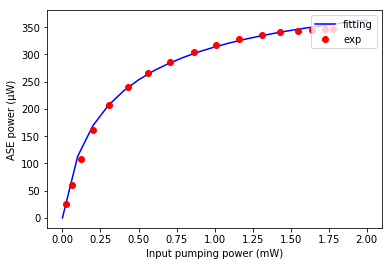

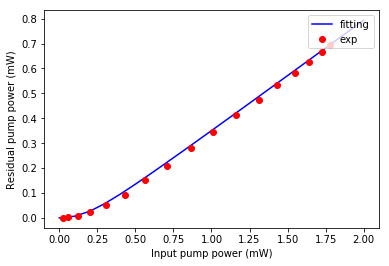

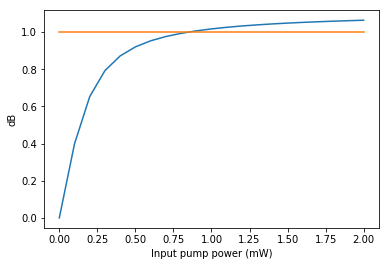

In [12]:
plt.figure('ASE')
plt.plot(p_f, Psf_out, 'b-', label = 'fitting')
plt.plot(pump_exp, ASE_exp, 'ro', label = 'exp')
plt.legend(loc = 'upper right')
plt.xlabel('Input pumping power (mW)')
plt.ylabel('ASE power (μW)')
#
plt.figure('Residual Pump')
plt.plot(p_f, res_fpump, 'b-',  label = 'fitting')
plt.plot(pump_exp, RsP_exp, 'ro', label = 'exp')
plt.legend(loc = 'upper right')
plt.xlabel('Input pump power (mW)')
plt.ylabel('Residual pump power (mW)')
#
plt.figure('Gain')
plt.plot(p_f, Gain, p_f, Loss_rt)
plt.xlabel('Input pump power (mW)')
plt.ylabel('dB')
#	
plt.show()
#######################################################################################################################################